In [26]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

# data extraction

In [5]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True, shuffle_files=True)

In [6]:
mnist_train, mnist_test = datasets['train'], datasets['test']

In [28]:
strategy = tf.distribute.MirroredStrategy()
print(f'Num of devices: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Num of devices: 1


In [16]:
num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

BUFFER_SIZE = 10000
BATCH_SIZE = 32
BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

In [17]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    
    return image, label

In [18]:
train_data = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_data = mnist_test.map(scale).batch(BATCH_SIZE)

# Sequantial Model

In [29]:
with strategy.scope():
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


# parameters initialization

In [7]:
keras.initializers.Zeros() # 全0
keras.initializers.Ones() # 全1
keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None) # 指定均值和方差的正态分布初始化
keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None) # 指定下边界和上边界的均匀分布初始化
keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None) # 截尾高斯分布初始化，位于均值两个标准差以外的数据将会被丢弃并重新生成，形成截尾分布

# training

In [30]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])
history = model.fit(train_data, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2563 - acc: 0.9266
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1139 - acc: 0.9666
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0789 - acc: 0.9765
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0579 - acc: 0.9820
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0454 - acc: 0.9858
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0346 - acc: 0.9891
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0293 - acc: 0.9910
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0237 - acc: 0.9927
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0186 - acc: 0.9944
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0164 - acc: 0.9948


# test

In [23]:
model.evaluate(eval_data)

    313/Unknown - 1s 3ms/step - loss: 0.0858 - acc: 0.9786

[0.08578590485142279, 0.9786]

# history plotting

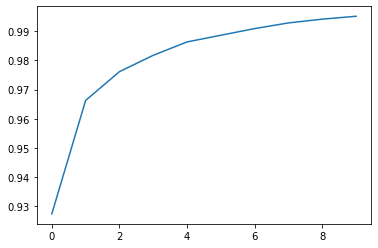

In [24]:
plt.plot(history.history['acc'])

# model save and load

In [37]:
model.save('./softmax_mnist_shortcut.h5')   #保存

In [33]:
new_model = keras.models.load_model('./softmax_mnist.h5')